In [20]:
import glob
import pandas as pd
from scapy.all import rdpcap, IP, TCP, UDP
import os

# Get all pcap files from the directory
pcap_files = glob.glob('/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary*')

pcap_dfs = {}

columns = [
    'frame.number', 'frame.time', 'ip.src', 'ip.dst',
    'tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport',
    'highest_layer', 'application_layer', 'http_payload'
 ]

for fname in pcap_files:
    packets = rdpcap(fname)
    rows = []
    for idx, pkt in enumerate(packets, 1):
        http_payload = None
        is_http = False
        # Check for HTTP in Raw layer on TCP port 80
        if TCP in pkt and pkt.haslayer('Raw') and (pkt[TCP].sport == 80 or pkt[TCP].dport == 80):
            raw_data = bytes(pkt['Raw'].load)
            try:
                http_text = raw_data.decode('utf-8', errors='replace')
                # Simple check for HTTP request/response
                if http_text.startswith(('GET ', 'POST ', 'HEAD ', 'PUT ', 'DELETE ', 'OPTIONS ', 'PATCH ', 'HTTP/')):
                    http_payload = http_text
                    is_http = True
            except Exception as e:
                pass
        row = {
            'frame.number': idx,
            'frame.time': pkt.time if hasattr(pkt, 'time') else None,
            'ip.src': pkt[IP].src if IP in pkt else None,
            'ip.dst': pkt[IP].dst if IP in pkt else None,
            'tcp.srcport': pkt[TCP].sport if TCP in pkt else None,
            'tcp.dstport': pkt[TCP].dport if TCP in pkt else None,
            'udp.srcport': pkt[UDP].sport if UDP in pkt else None,
            'udp.dstport': pkt[UDP].dport if UDP in pkt else None,
            'highest_layer': 'HTTP' if is_http else ('TCP' if TCP in pkt else ('UDP' if UDP in pkt else (pkt.name if hasattr(pkt, 'name') else None))),
            'application_layer': 'HTTP' if is_http else (pkt.lastlayer().name if hasattr(pkt, 'lastlayer') else None),
            'http_payload': http_payload
        }
        rows.append(row)
    df = pd.DataFrame(rows, columns=columns)
    pcap_dfs[fname] = df

pcap_files

['/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary6.pcap',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary3.pcap',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary1.pcap',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary8.pcapng',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary2.pcap',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary7.pcap',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary5.pcap',
 '/home/ace-student/Documents/challenge_problem_7/CovertChannelChap/Analysis/intel/adversary4.pcap']

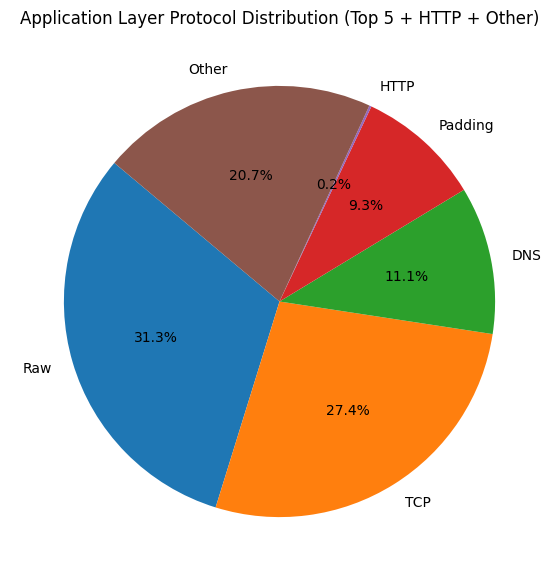

In [23]:
import matplotlib.pyplot as plt

# Ensure HTTP is always in the top protocols
http_count = protocol_counts.get('HTTP', 0)
sorted_counts = sorted(protocol_counts.items(), key=lambda x: x[1], reverse=True)

# Remove HTTP from sorted_counts if present
sorted_counts = [item for item in sorted_counts if item[0] != 'HTTP']

# Take top X-1 protocols (since HTTP will be added separately)
top = sorted_counts[:X-1]

# Add HTTP as a separate slice if present
if http_count > 0:
    top.append(('HTTP', http_count))

# Recalculate 'other'
other = sorted_counts[X-1:]
other_count = sum(count for _, count in other)

labels = [proto for proto, _ in top]
sizes = [count for _, count in top]
if other_count > 0:
    labels.append("Other")
    sizes.append(other_count)

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Application Layer Protocol Distribution (Top {} + HTTP + Other)'.format(X))
plt.savefig("./images/Protocol_pie_chart")

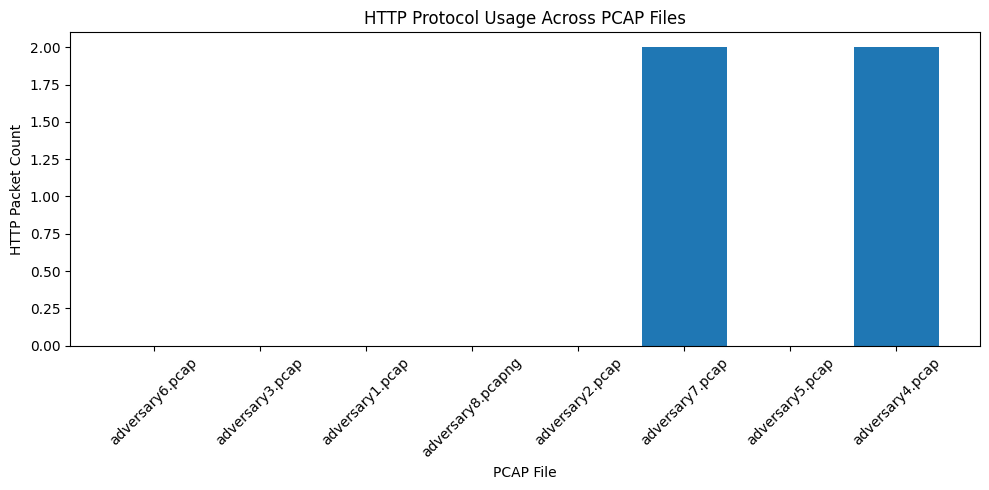

In [22]:
# Count HTTP protocol occurrences in each pcap file
http_counts = {}
for fname, df in pcap_dfs.items():
    count = df['application_layer'].str.contains('HTTP', case=False, na=False).sum()
    http_counts[fname] = count

# Plot HTTP usage per file
plt.figure(figsize=(10, 5))
plt.bar(range(len(http_counts)), list(http_counts.values()), tick_label=[f.split('/')[-1] for f in http_counts.keys()])
plt.ylabel('HTTP Packet Count')
plt.xlabel('PCAP File')
plt.title('HTTP Protocol Usage Across PCAP Files')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Extract packet number 19 and 20 from adversary4.pcap
packets_19_20 = packets[18:20]  # scapy uses zero-based indexing
for i, pkt in enumerate(packets_19_20, start=19):
    print(f"Packet {i}: {pkt.summary()}")

Packet 19: Ether / IP / TCP 192.168.3.65:50194 > 185.125.190.49:http PA / Raw
Packet 20: Ether / IP / TCP 185.125.190.49:http > 192.168.3.65:50194 PA / Raw
